---
# NLP
---

In this notebook, we wil be using a NLP model (BERT- Sentiment) to convert the comments into a rating from 1 to 10, since a lot (25%) of the ratings are missing. 

We also tried various NLP model to summarize a text and another to retain the most import keywords from a text. Due to lack of time this portion was discarded for the rest of the project.

The resulting Sentiment ratings with the original datset will be written to the [Output File](../data/games_comments_sentiment_summarized.csv) 

---


### Importing necessary library

In [1]:
import pandas as pd
import numpy as np

import requests
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from summarizer import Summarizer,TransformerSummarizer
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
#from summarizer import Summarizer,TransformerSummarizer
#from transformers import pipeline

2025-03-27 11:59:59.861735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743091200.307194 1873299 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743091200.355162 1873299 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743091201.197262 1873299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743091201.197369 1873299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743091201.197376 1873299 computation_placer.cc:177] computation placer alr

---

<center>
    
## Preparing data

</center>

---

### Read data file

In [2]:
df = pd.read_csv('../data/games_comments_clean.csv')
df

,username,rating,comment,gamename,mechanics,min_players,max_players,minplaytime,maxplaytime,age,ratings_avg,count_wanting,count_wishing,description,categories,lang
0,causticforever,NaN,Played prototype- will be an enjoyable way to ...,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en
1,Corwin007,NaN,UPCOMING\n\nArk Nova lite?,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en
2,IronTarkles,NaN,New game from ark nova designer,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en
3,MarkyX,NaN,I'm very interested in this one. I like the co...,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en
4,mikamikomi,1.0,3 artist yet still use stock photos? oh yeah,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,chicagometh,4.8,"4...'Not so good, but could play again' by BGG...",Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en
4194,Chris Coyote,NaN,Birthday 2025,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en
4195,Chris_P85,9.0,Played a half Game at Spiel 24,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en
4196,Chutch1035,5.0,I love Feld games and I love Civ games. When I...,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en


---

<center>
    
## NLP - Sentiment

</center>

---

### Create an instance of the model

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

### Encode the reviews and use model to predict sentiment for each review

In [4]:
# Creating function to encode each review and return the sentiment score from 1 to 5 
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    rating_1_5 = torch.argmax(result.logits).item() + 1
    rating_1_10 = np.round(2 * rating_1_5, decimals=1)
    return rating_1_10

In [5]:
# Add Sentiment column that contains the sentiment prediction of the model based on the review
df['Sentiment'] = df['comment'].apply(lambda x: sentiment_score(x[:512]))
df

,username,rating,comment,gamename,mechanics,min_players,max_players,minplaytime,maxplaytime,age,ratings_avg,count_wanting,count_wishing,description,categories,lang,Sentiment
0,causticforever,NaN,Played prototype- will be an enjoyable way to ...,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en,8
1,Corwin007,NaN,UPCOMING\n\nArk Nova lite?,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en,6
2,IronTarkles,NaN,New game from ark nova designer,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en,10
3,MarkyX,NaN,I'm very interested in this one. I like the co...,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en,8
4,mikamikomi,1.0,3 artist yet still use stock photos? oh yeah,Sanctuary,"Action Queue,Hand Management,Hexagon Grid,Open...",1,5,40,100,12,7.00000,55,569,"In Sanctuary, you will plan and design a moder...","Animals,Environmental,Territory Building",en,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,chicagometh,4.8,"4...'Not so good, but could play again' by BGG...",Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en,8
4194,Chris Coyote,NaN,Birthday 2025,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en,10
4195,Chris_P85,9.0,Played a half Game at Spiel 24,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en,2
4196,Chutch1035,5.0,I love Feld games and I love Civ games. When I...,Civolution,"Area Movement,Dice Rolling,Events,Hand Managem...",1,4,90,180,14,8.21282,580,4089,"Hello, student beings! The cosmic faculty of t...","Civilization,Dice,Economic,Exploration,Science...",en,8


---

<center>
    
## NLP - Summarization

</center>

---

**BERT**

bert_model = Summarizer()

def comment2summaryBERT(comment):
    summary = ''.join(bert_model(comment, max_length=50, min_length=1))
    return summary

 Add Summary column that contains the summary of the comment based on NLP summarization
df['Summary_BERT'] = df['comment'].apply(lambda x: comment2summaryBERT(x))
df

**KeyBERT**

model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

kw_model = KeyBERT(model)

def comment2keyBERT(comment):
    keywords = kw_model.extract_keywords("I'm very interested in this one. Love blabla", keyphrase_ngram_range=(1, 1), top_n=5)
    #summary = ''.join(kw_model(comment, keyphrase_ngram_range=(1, 2), top_n=1))
    return [k[0] for k in keywords]

df['KeyBERT'] = df['comment'].apply(lambda x: comment2keyBERT(x))
df

**BART**

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def comment2summaryBART(comment):
    summary = summarizer(comment, max_length=5, min_length=1, do_sample=False)
    return summary

df['Summary_BERT'] = df['comment'].apply(lambda x: comment2summaryBART(x))
df

df

---

<center>
    
## Saving data to file

</center>

---

In [6]:
df.to_csv('../data/games_comments_sentiment_summarized.csv', index=False)

---

<center>
    
## Evaluate Sentiment rating vs true rating

</center>

---

In [7]:
tmp = df.dropna(subset=['rating'])

In [8]:
tmp['rating'].unique()

array([ 1.  ,  9.  ,  8.  ,  8.5 ,  7.  ,  4.  ,  7.5 ,  5.5 ,  7.3 ,
       10.  ,  5.  ,  6.  ,  6.5 ,  8.4 ,  8.2 ,  9.2 ,  9.5 ,  9.3 ,
        8.8 ,  7.8 ,  3.  ,  6.8 ,  7.2 ,  7.1 ,  6.4 ,  7.9 ,  8.36,
        9.6 ,  6.05,  7.7 ,  8.6 ,  9.4 ,  2.  ,  8.7 ,  8.75,  8.3 ,
        3.7 ,  6.6 ,  7.75,  6.3 ,  4.5 ,  3.5 ,  9.75,  7.6 ,  2.5 ,
        9.21,  7.25,  7.65,  8.79,  4.9 ,  9.9 ,  6.1 ,  8.64,  8.9 ,
        8.25,  8.33,  5.9 ,  6.57,  9.45,  9.1 ,  7.4 ,  7.84,  9.25,
        4.8 ])

In [9]:
tmp = tmp[tmp['rating'] != 'rating']

In [10]:
tmp['rating'] = tmp['rating'].astype(float)

In [11]:
tmp['rating'] = round(tmp['rating'] / 2) * 2

In [12]:
tmp['rating'] = tmp['rating'].astype(int)

In [13]:
tmp['rating'].unique()

array([ 0,  8,  4,  6, 10,  2])

In [14]:
tmp['rating'] = tmp['rating'].replace({0:2})

In [15]:
tmp['rating'].unique()

array([ 2,  8,  4,  6, 10])

In [16]:
tmp['Sentiment'].unique()

array([ 6,  8, 10,  2,  4])

In [17]:
print("Classification Report:\n", classification_report(tmp['rating'], tmp['Sentiment']))

Classification Report:
               precision    recall  f1-score   support

           2       0.11      0.48      0.18        44
           4       0.47      0.39      0.43       230
           6       0.16      0.43      0.23       216
           8       0.76      0.40      0.53      1756
          10       0.41      0.65      0.50       597

    accuracy                           0.46      2843
   macro avg       0.38      0.47      0.37      2843
weighted avg       0.60      0.46      0.48      2843



### Comparing distribution count of Sentiment values vs Ratings 

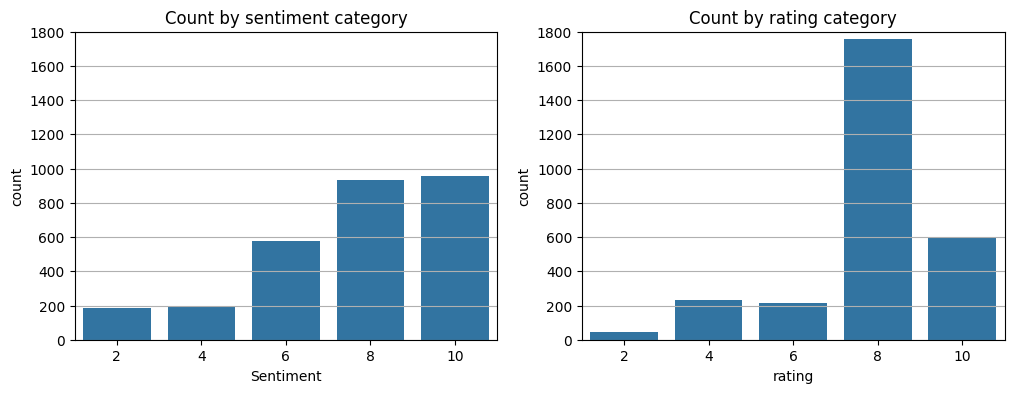

In [19]:
# Create the figure and adjust its size
fig , (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

sns.countplot(ax=ax2, data=tmp,x='rating', order=[2,4,6,8,10])
sns.countplot(ax=ax1, data=tmp,x='Sentiment', order=[2,4,6,8,10])

# Set the axis labels 
ax1.set_xlabel('Rating')
ax1.set_xlabel('Sentiment')

# Set Title
ax1.set_title('Count by sentiment category')
ax2.set_title('Count by rating category')

# Set y-axis limit
ax1.set_ylim(0,1800)
ax2.set_ylim(0,1800)

# Show grid on y axis
ax1.grid(axis='y')
ax2.grid(axis='y')

# Save plot
plt.savefig('../graph/SentimentvsRating.png')

# Show plot
plt.show()

---

<center>
    
## Results

</center>

---